In [2]:
from cloudvolume import CloudVolume, Skeleton
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from skimage import io 
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from brainlit.utils.Neuron_trace import NeuronTrace
from copy import deepcopy
from tqdm import tqdm
from scipy.interpolate import splev, splprep
from brainlit.BrainLine.util import json_to_points
import json


In [ ]:
vol = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/average_100um")
im_og = np.array(vol[:,:,:])

In [ ]:
v = np.arange(im_og.shape[0])
h = np.arange(im_og.shape[1])
d = np.arange(im_og.shape[2])

image_interp = RegularGridInterpolator((v,h,d), im_og, bounds_error=False, fill_value=0)

plt.imshow(im_og[:,:,72])
print(im_og.shape)

In [ ]:
# x is vertical component, y is horizontal
def deformation(v, h):
    y_disp = np.exp(-1*h/20)*np.exp(-1*(v-66)**2/1000)*20
    return y_disp

v_mat, h_mat = np.meshgrid(np.arange(0,132,10), np.arange(0,80,15))
v_flat = np.reshape(v_mat, (-1,1))
h_flat = np.reshape(h_mat, (-1,1))
y_displacements = deformation(v_flat, h_flat)
y_displacements = np.reshape(y_displacements, v_mat.shape)

plt.imshow(im_og[:,:,72], cmap='gray')
plt.quiver(h_mat, v_mat, y_displacements, 0*y_displacements, scale = 1, scale_units='x', facecolor='red')

In [ ]:
v_mat, h_mat, d_mat = np.meshgrid(v, h, d)
v_mat = np.swapaxes(v_mat, 0,1)
h_mat = np.swapaxes(h_mat, 0,1)
d_mat = np.swapaxes(d_mat, 0,1)
print(v_mat.shape)
v_flat = np.reshape(v_mat, (-1))
h_flat = np.reshape(h_mat, (-1))
d_flat = np.reshape(d_mat, (-1))

h_displacements = deformation(v_flat, h_flat)
new_h = h_flat - h_displacements

In [ ]:
points = np.stack([v_flat, new_h, d_flat], axis=1)
new_im_flat = image_interp(points)
new_im = np.reshape(new_im_flat,v_mat.shape)
new_im = new_im.astype('uint16')
plt.imshow(new_im[:,:,72], cmap='gray')

In [ ]:
for name, data in zip(["og", "new"], [im_og, new_im]):
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=vol.voxel_offset,  # x,y,z offset in voxels from the origin
        # mesh            = 'mesh',
        # Pick a convenient size for your underlying chunk representation
        # Powers of two are recommended, doesn't need to cover image exactly
        chunk_size=vol.chunk_size,  # units are voxels
        volume_size=vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    local_vol = CloudVolume(f"precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/{name}/", info=info, compress=False)
    local_vol.commit_info()
    local_vol[:,:,:] = data


## Register

`python -m cloudreg.scripts.registration -input_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new/ --output_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/average_100um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/annotation_100um_2017 --atlas_orientation PIR -orientation PIR --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1 -log_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/log/ --missing_data_correction False --grid_correction False --bias_correction False --regularization 5000.0 --iterations 3000 --registration_resolution 100`

python -m cloudreg.scripts.transform_points --target_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=aB9pLBQXd6Liyg" --atlas_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg" --affine_path "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_A.mat" --velocity_path "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_v.mat" --transformation_direction "atlas"

In [3]:

velocity_path = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_v.mat"
affine_path = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_A.mat"

ct = CloudReg_Transform(velocity_path, affine_path)

vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new")
shp = np.array(vol.shape)
res = np.array(vol.resolution) / 1000
origin = (shp[:3] - 1) * res / 2


integrating velocity field: 100%|██████████| 10/10 [00:40<00:00,  4.10s/it]


In [4]:

coords_ng = json_to_points(url = "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=aB9pLBQXd6Liyg")['points']
coords_skel = np.multiply(coords_ng, 1000 * res)

coords_centered = coords_skel / 1000 - origin
coords_affine = ct.apply_affine(coords_centered)
coords_transform = ct.evaluate(coords_affine)
coords_ng_atlas = np.divide(coords_transform, 10) + (np.array([1320, 800, 1140])-1) / 2

1st order mappings: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


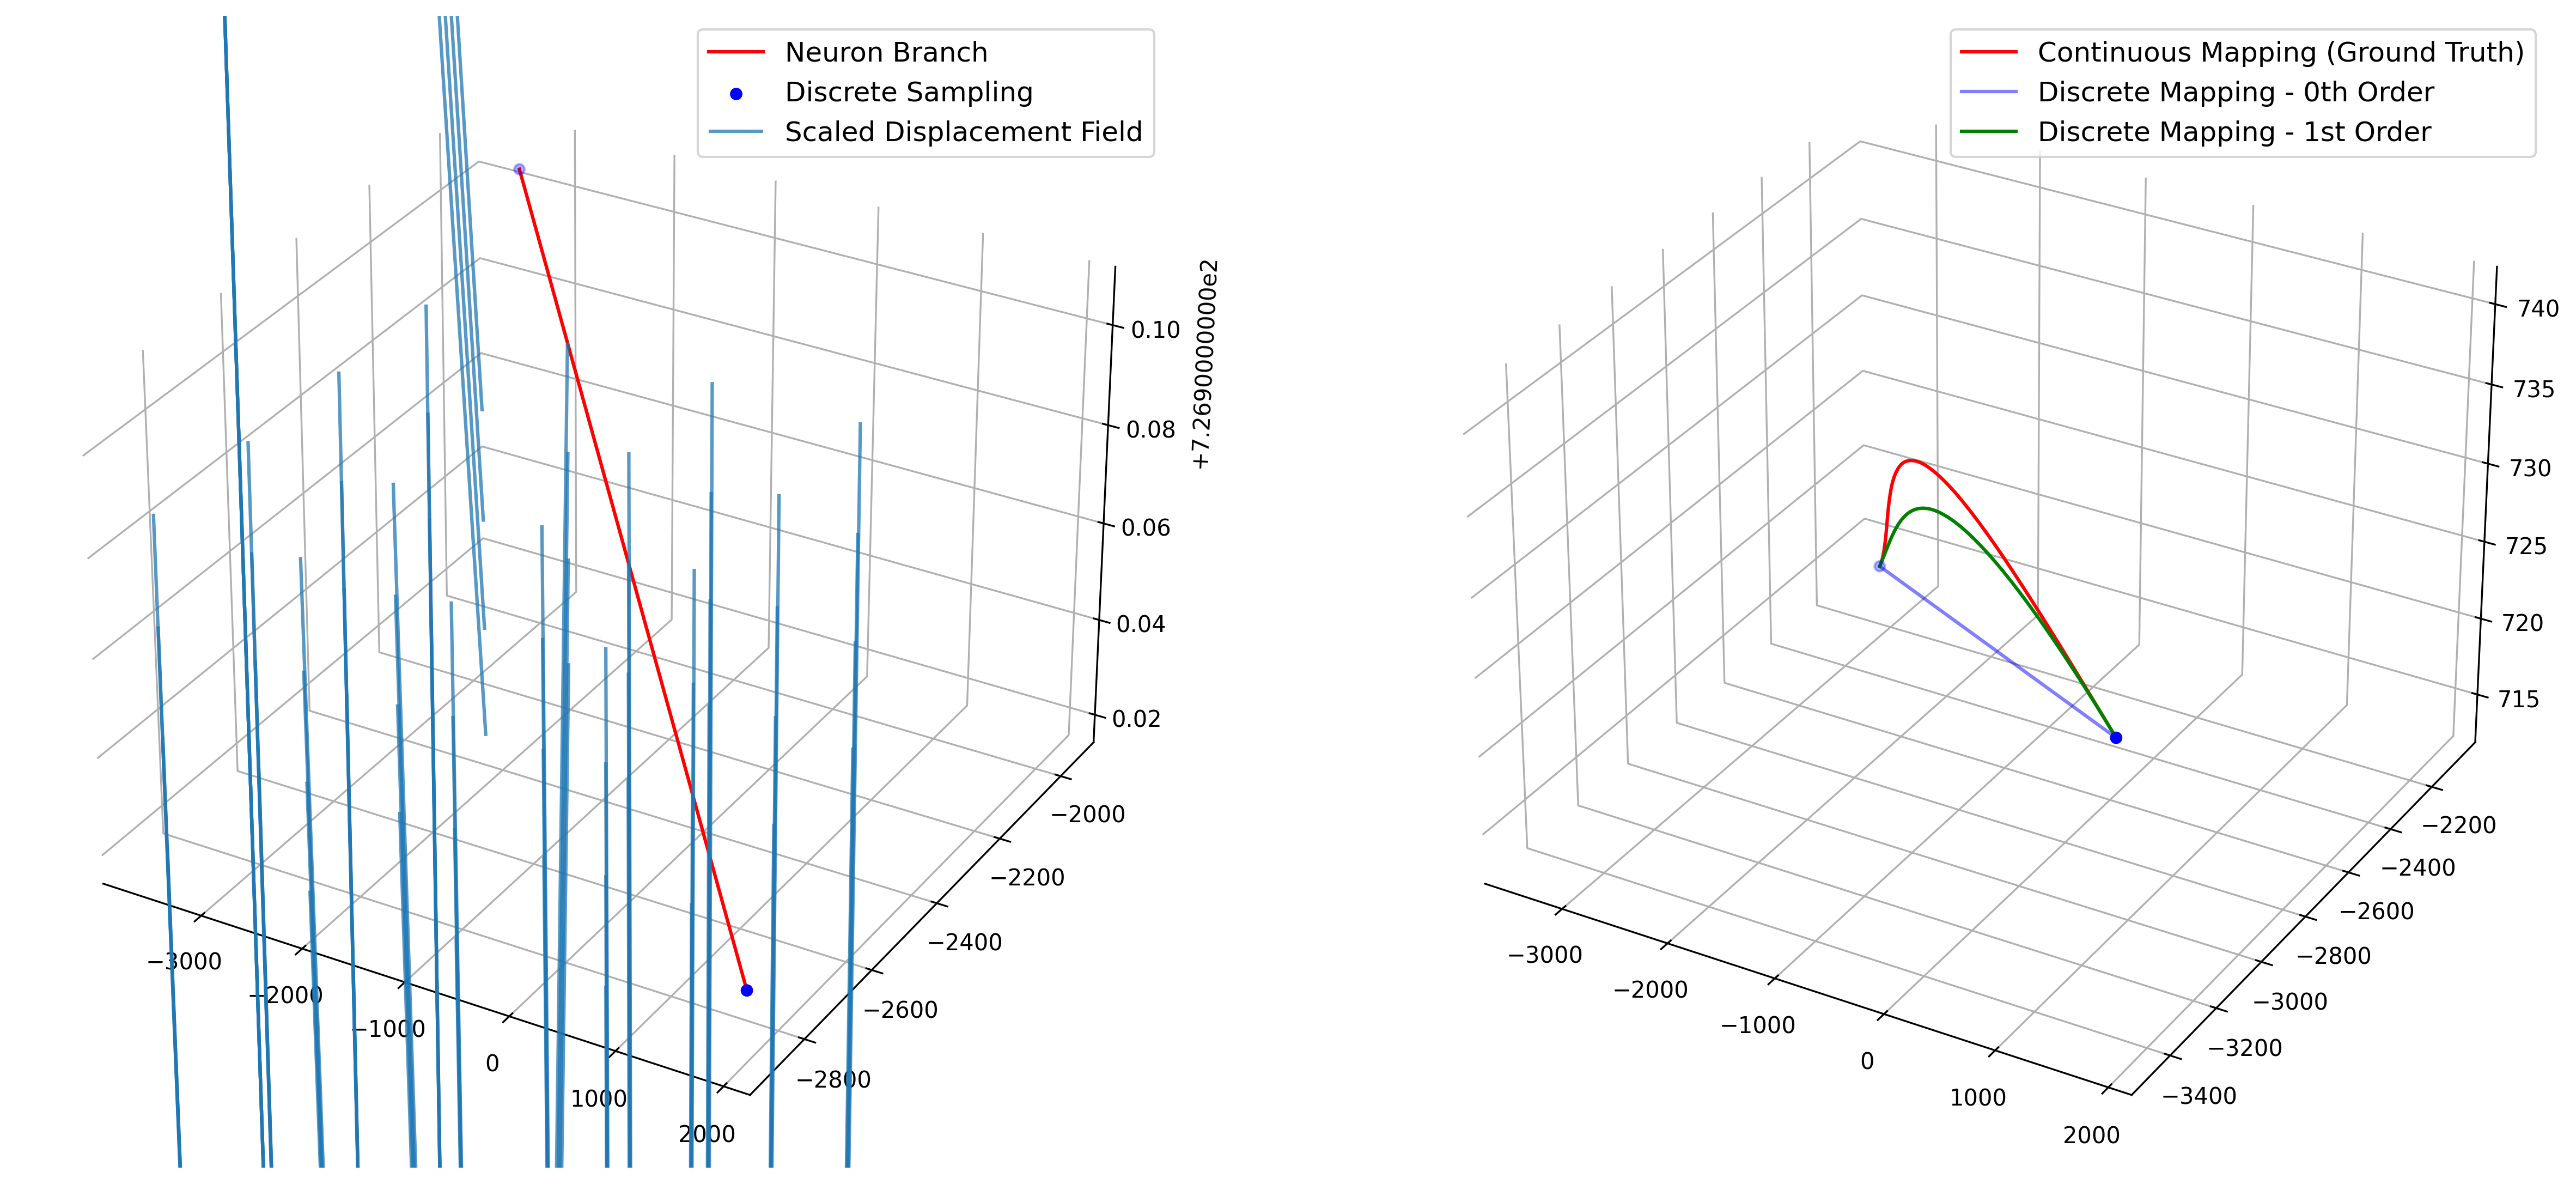

In [5]:
coords = coords_centered

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
    if id > 0:
        G.add_edge(id-1,id)

spline_tree = G.fit_spline_tree_invariant()
# Target space
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    label = "Neuron Branch"
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    ax.scatter(
        pts[0], pts[1], pts[2], linestyle="-", label="Discrete Sampling", color="blue"
    )
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=3,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)

ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    label = "Continuous Mapping (Ground Truth)"
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    label = "Discrete Mapping - 0th Order"
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    ax.scatter(trans_pts[:, 0], trans_pts[:, 1], trans_pts[:, 2], color="blue")
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    label = "Discrete Mapping - 1st Order"
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

In [7]:
vol_atlas = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")


In [7]:

vol_atlas = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol_atlas.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol_atlas.voxel_offset,  # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size=vol_atlas.chunk_size,  # units are voxels
    volume_size=vol_atlas.volume_size,  # e.g. a cubic millimeter dataset
    skeletons="skeletons"
)
vol_atlas_skels = CloudVolume(f"precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_skels/", info=info, compress=False)
vol_atlas_skels.commit_info()
vol_atlas_skels.skeleton.meta.commit_info()

# remove vertex type attribute because it is a uint8 and incompatible with neuroglancer
info_path = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_skels/skeletons/info"
with open(info_path) as f:
    data = json.load(f)
    for i, attr in enumerate(data["vertex_attributes"]):
        if attr["id"] == "vertex_types":
            data["vertex_attributes"].pop(i)
            break

with open(info_path, "w") as f:
    json.dump(data, f)


In [12]:
trans_pts_atlas = np.divide(trans_pts, 10) + (np.array([1320, 800, 1140])-1) / 2

trans_pts_atlas = trans_pts_atlas * vol_atlas.resolution

vol_atlas_skels = CloudVolume(f"precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_skels/", compress=False)
skel = Skeleton(
            segid=0, vertices=trans_pts_atlas, edges=[[i - 1, i] for i in range(1, len(trans_pts))], space="voxel"
        )
vol_atlas_skels.skeleton.upload(skel)

In [8]:
pts_atlas = np.divide(pts, 10) + (np.array([1320, 800, 1140])-1) / 2

pts_atlas = pts_atlas * vol_atlas.resolution

vol_atlas_skels = CloudVolume(f"precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_skels/", compress=False)
skel = Skeleton(
            segid=1, vertices=pts_atlas, edges=[[i - 1, i] for i in range(1, len(trans_pts))], space="voxel"
        )
vol_atlas_skels.skeleton.upload(skel)

In [9]:
pts_atlas.shape

(537032, 3)